In [1]:
import torch
import random
from typing import NamedTuple
# pip install dm-tree
import tree
import matplotlib.pyplot as plt

In [2]:
class LTI_Params(NamedTuple):
    A: torch.Tensor
    B: torch.Tensor
    C: torch.Tensor
    D: torch.Tensor

def _draw_lti_params_continuous_time(state_dim: int) -> LTI_Params:
    "Dummy implementation"
    return LTI_Params(
        A=torch.eye(state_dim),
        B=torch.ones((state_dim, 1)),
        C=torch.ones((1, state_dim)),
        D=torch.zeros((1, 1))
    )

def _explicit_euler(A, B, C, D, x, u, dt):
    "-> (next_x, y)"
    x = x + (A @ x + B @ u) * dt
    return x, C @ x + D @ u


class LTI:
    def __init__(self, bs: int, N: int, dt: float, state_dim: int) -> None:
        assert N >= bs
        self._bs = bs
        self._dt = dt
        self._state_dim = state_dim

        self._lti_N: list[LTI_Params] = [_draw_lti_params_continuous_time(state_dim) for _ in range(N)]

        self.reset()

    def step(self, action: torch.Tensor) -> torch.Tensor:
        assert action.shape == (self._bs, 1), f"action.shape={action.shape}"
        action = torch.arctan(action)
        self._x, y = torch.vmap(_explicit_euler, in_dims=(0, 0, 0, 0, 0, 0, None))(
            self._lti_bs.A, self._lti_bs.B, self._lti_bs.C, self._lti_bs.D, self._x, action, self._dt)
        return y

    def reset(self) -> None:
        self._x = torch.zeros((self._bs, self._state_dim))
        lti_bs: list[LTI_Params] = random.choices(self._lti_N, k=self._bs)
        self._lti_bs: LTI_Params = tree.map_structure(lambda *arr: torch.vstack([a[None] for a in arr]), *lti_bs)


class Controller(torch.nn.Module):
    def __init__(self, hidden_size: int, batch_size: int) -> None:
        super().__init__()
        self.f = torch.nn.Linear(hidden_size, 1)
        self.g = torch.nn.GRUCell(2, hidden_size)
        self._h0 = torch.zeros((batch_size, hidden_size))
        self.reset()

    def forward(self, ref, obs):
        assert ref.ndim == 2
        assert ref.shape == obs.shape
        x = torch.concat((ref, obs), dim=-1)
        self._h = self.g(x, self._h)
        return self.f(self._h)
    
    def reset(self):
        self._h = self._h0



In [3]:
# batchsize
BS = 4
# number of random LTI systems
N = 10
# timestep size
dt = 0.01
# size of LTI system state
state_dim = 3
# max time horizon / finite trial duration
T = 5.0
# number of training steps
n_steps = 500
# learning rate
lr = 3e-3
# GRU hidden state size
hidden_size = 10


lti = LTI(BS, N, dt, state_dim)
ctrb = Controller(hidden_size, BS)
opt = torch.optim.SGD(ctrb.parameters(), lr, momentum=0.9)
ref = torch.arange(BS)[:, None].repeat(1, int(T / dt)).T[..., None]


for _ in range(n_steps):

    i = 0
    action = torch.zeros((BS, 1))
    ys = []
    lti.reset()
    ctrb.reset()
    while i < len(ref):
        y = lti.step(action)
        action = ctrb(ref[i], y)
        i += 1
        ys.append(y)

    ys = torch.stack(ys)
    loss = torch.mean((ys - ref)**2)

    opt.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad.clip_grad_norm_(ctrb.parameters(), 0.5)
    opt.step()


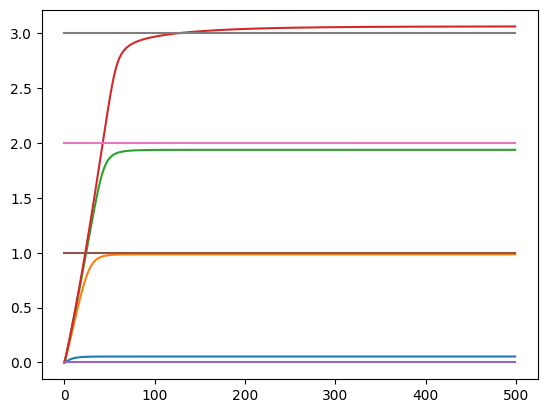

In [5]:
plt.plot(ys.detach().numpy()[:, :, 0])
plt.plot(ref[:, :, 0])
plt.show()